In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sourcesep.utils.config import load_config

sns.set_theme(font_scale=0.8)
%config InlineBackend.figure_format='retina'

paths = load_config(dataset_key="all")

Paths are for dataset tagged: all


In [2]:
GCaMP8s_1 = pd.read_hdf(paths["pilot"] / "test.hdf5", key="GCaMP8s_1", more="r")
print(GCaMP8s_1.head(2), "\n")

GCaMP8s_2 = pd.read_hdf(paths["pilot"] / "test.hdf5", key="GCaMP8s_2", more="r")
print(GCaMP8s_2.head(2), "\n")

GCaMP8s_3 = pd.read_hdf(paths["pilot"] / "test.hdf5", key="GCaMP8s_3", more="r")
print(GCaMP8s_3.head(2), "\n")

       time       signal
0  0.000000  2539.738556
1  0.024409  2556.222711 

      time       signal
0  0.00000  1646.507353
1  0.07469  1665.477941 

       time       signal
0  0.000000  2112.720760
1  0.013369  2095.124269 



In [3]:
HbAbs = pd.read_csv(paths["spectra"] / "HbAbs.csv")
print(HbAbs.head(2), "\n")

Venus = pd.read_csv(paths["spectra"] / "Venus.csv")
print(Venus.head(2), "\n")

EGFP = pd.read_csv(paths["spectra"] / "EGFP.csv")
print(EGFP.head(2), "\n")

mApple = pd.read_csv(paths["spectra"] / "mApple.csv")
print(mApple.head(2), "\n")

   wavelength  Hb02 (cm-1/M)  Hb (cm-1/M)
0         250       106112.0     112736.0
1         252       105552.0     112736.0 

   wavelength  Venus ex  Venus em
0         350    0.0484       NaN
1         351    0.0483       NaN 

   wavelength  EGFP ex  EGFP em  EGFP 2p
0         300   0.0962      NaN      NaN
1         301   0.0872      NaN      NaN 

   wavelength  mApple ex  mApple em
0         300     0.2221        NaN
1         301     0.1939        NaN 



 - $µ_\textrm{oxy}(\lambda)$ is column `Hb02` in HbAbs
 - $µ_\textrm{deoxy}(\lambda)$ is column `Hb` in HbAbs

### Extinction coefficient for hemoglobin
 - source: https://omlc.org/spectra/hemoglobin/summary.html
 - $\varepsilon$ is extinction coefficient (in per centimeter per Molar; Molar is moles per Liter)
 - $x$ is in grams per liter (100 grams per liter for Hemoglobin)
 - $l$ is effective cuvette length (~0.05 cm, is a function of wavelength, and changes with time)
 - $M_{\textrm{Hg}}$ is molar mass of Hemoglobin (in grams per mole) = 64,500 g/mole
 - $A$ is the absorbance, calculated as $A = \frac{\varepsilon \times x \times {l}}{M_{\textrm{Hg}}}$

### In the brain:
 - $x$ is a function of time, ranging roughly from 100 to 200 g/L
 - This is because the fraction of oxy to deoxy hemoglobin changes over time
 - Using Beer Lambert's law: $\frac{I}{I_o} = e^{-A}$
 - Replacing A: $$I(\lambda, t) = I_o(\lambda, t) e^{-\frac{\varepsilon \times x(t) \times {l(\lambda)}}{M_{\textrm{Hg}}}}$$
 

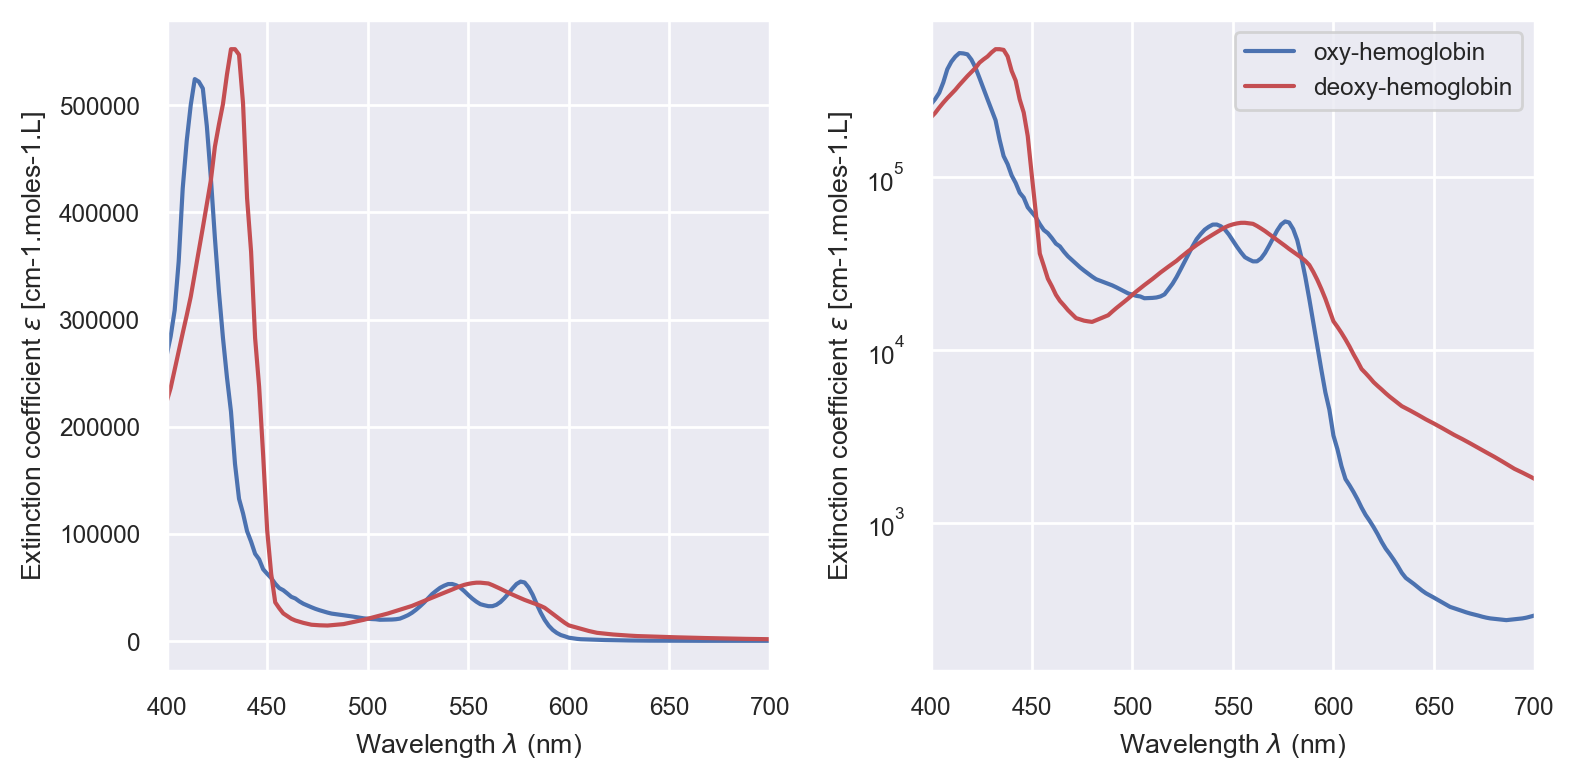

In [4]:
# to do set y to log scale
f, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(HbAbs["wavelength"], HbAbs["Hb02 (cm-1/M)"], label="oxy-hemoglobin", c="b")
ax[0].plot(HbAbs["wavelength"], HbAbs["Hb (cm-1/M)"], label="deoxy-hemoglobin", c="r")
ax[0].set(
    xlabel=r"Wavelength $\lambda$ (nm)",
    ylabel=r"Extinction coefficient $\varepsilon$ [cm-1.moles-1.L]",
    yscale="linear",
    xlim=(400, 700),
)

ax[1].plot(HbAbs["wavelength"], HbAbs["Hb02 (cm-1/M)"], label="oxy-hemoglobin", c="b")
ax[1].plot(HbAbs["wavelength"], HbAbs["Hb (cm-1/M)"], label="deoxy-hemoglobin", c="r")
ax[1].set(
    xlabel=r"Wavelength $\lambda$ (nm)",
    ylabel=r"Extinction coefficient $\varepsilon$ [cm-1.moles-1.L]",
    yscale="log",
    xlim=(400, 700),
)

plt.legend()
plt.tight_layout()
plt.show()

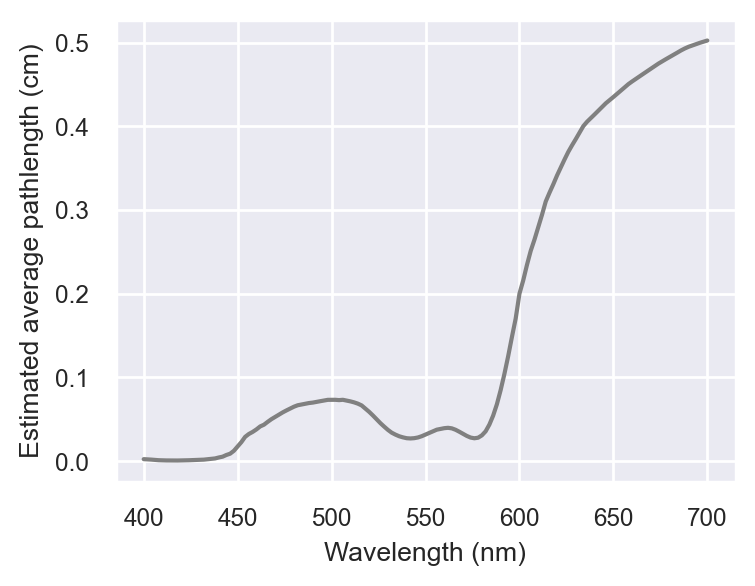

In [5]:
df = pd.read_csv(paths["spectra"] / "pathlength.csv")
f, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(df["Wavelength (nm)"], df["Estimated average pathlength (cm)"], c="gray")
ax.set(xlabel="Wavelength (nm)", ylabel="Estimated average pathlength (cm)")
plt.show()

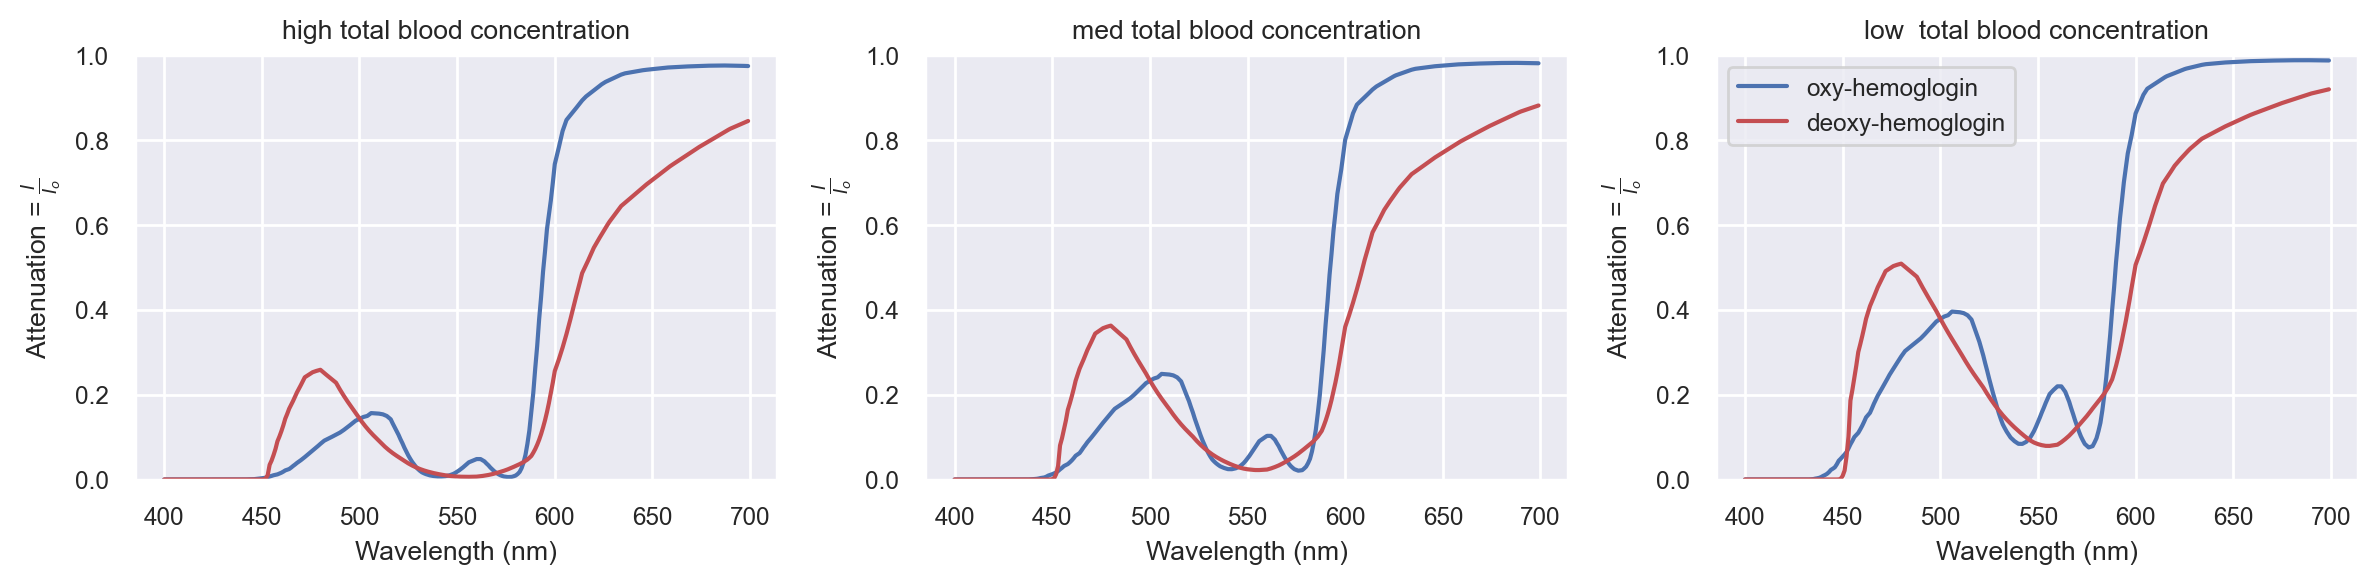

In [6]:
L_arr = np.arange(400, 700, 1)
# l = np.interp(x=L_arr, xp=df['Wavelength (nm)'], fp=df['Estimated average pathlength (cm)'])  # cm
l = 0.03  # cm (0.3 mm)
e_ox = np.interp(x=L_arr, xp=HbAbs["wavelength"], fp=HbAbs["Hb02 (cm-1/M)"])  # cm-1.mol-1.L
e_dox = np.interp(x=L_arr, xp=HbAbs["wavelength"], fp=HbAbs["Hb (cm-1/M)"])  # cm-1.mol-1.L
M = 64500  # g/mol

# Plots for different blood concentrations.
f, ax = plt.subplots(1, 3, figsize=(12, 3))
x = [200, 150, 100]  # g/L
lbl = ["high total blood concentration", "med total blood concentration", "low  total blood concentration"]
for i, a in enumerate(ax):
    att_lo_ox = np.exp(-1 * l * e_ox * x[i] / M)
    att_lo_dox = np.exp(-1 * l * e_dox * x[i] / M)
    a.plot(L_arr, att_lo_ox, "b-", label="oxy-hemoglogin")
    a.plot(L_arr, att_lo_dox, "r-", label="deoxy-hemoglogin")
    a.set(xlabel="Wavelength (nm)", ylabel=r"Attenuation = $\frac{I}{I_o}$", title=lbl[i], ylim=(0, 1))
plt.tight_layout()
plt.legend()
plt.show()

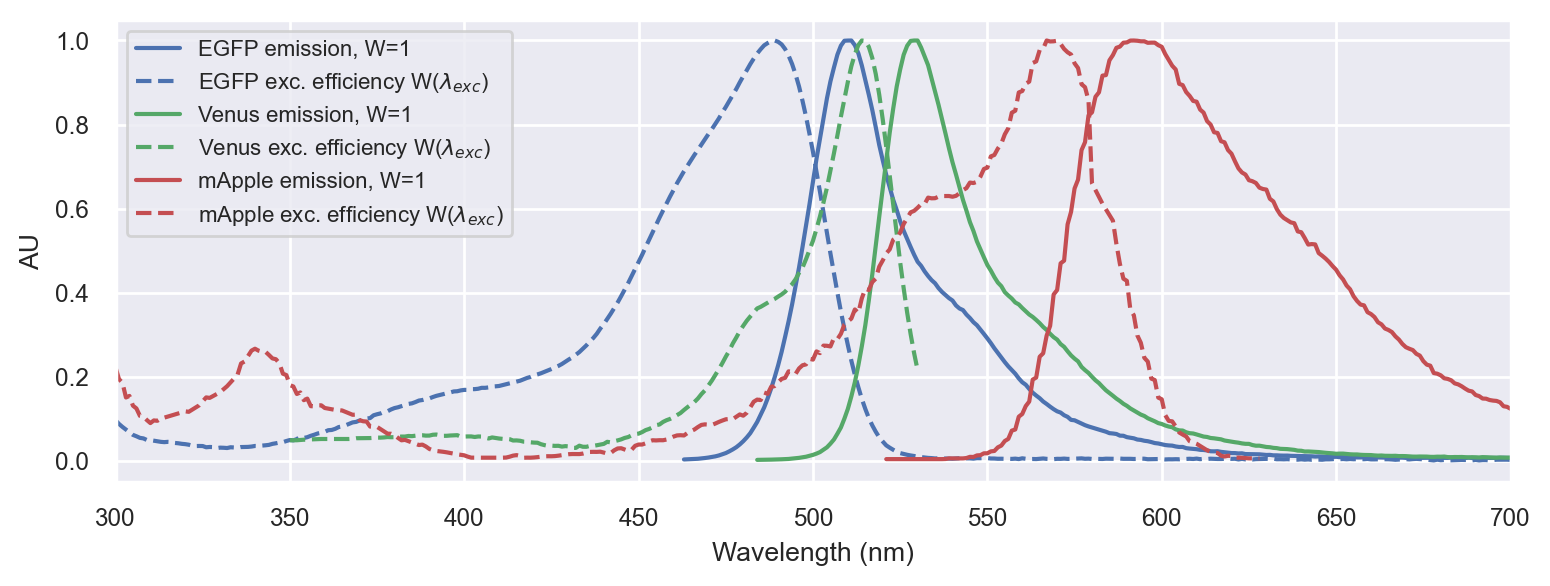

In [7]:
f, ax = plt.subplots(1, 1, figsize=(9, 3))
ax.plot(EGFP["wavelength"], EGFP["EGFP em"], "-", c="b", label=r"EGFP emission, W=1")
ax.plot(EGFP["wavelength"], EGFP["EGFP ex"], "--", c="b", label=r"EGFP exc. efficiency W($\lambda_{exc}$)")

ax.plot(Venus["wavelength"], Venus["Venus em"], "-", c="g", label=r"Venus emission, W=1")
ax.plot(Venus["wavelength"], Venus["Venus ex"], "--", c="g", label=r"Venus exc. efficiency W($\lambda_{exc}$)")

ax.plot(mApple["wavelength"], mApple["mApple em"], "-", c="r", label=r"mApple emission, W=1")
ax.plot(mApple["wavelength"], mApple["mApple ex"], "--", c="r", label=r"mApple exc. efficiency W($\lambda_{exc}$)")

ax.set(xlim=(300, 700), xlabel="Wavelength (nm)", ylabel="AU")
plt.legend(fontsize=8)
plt.show()

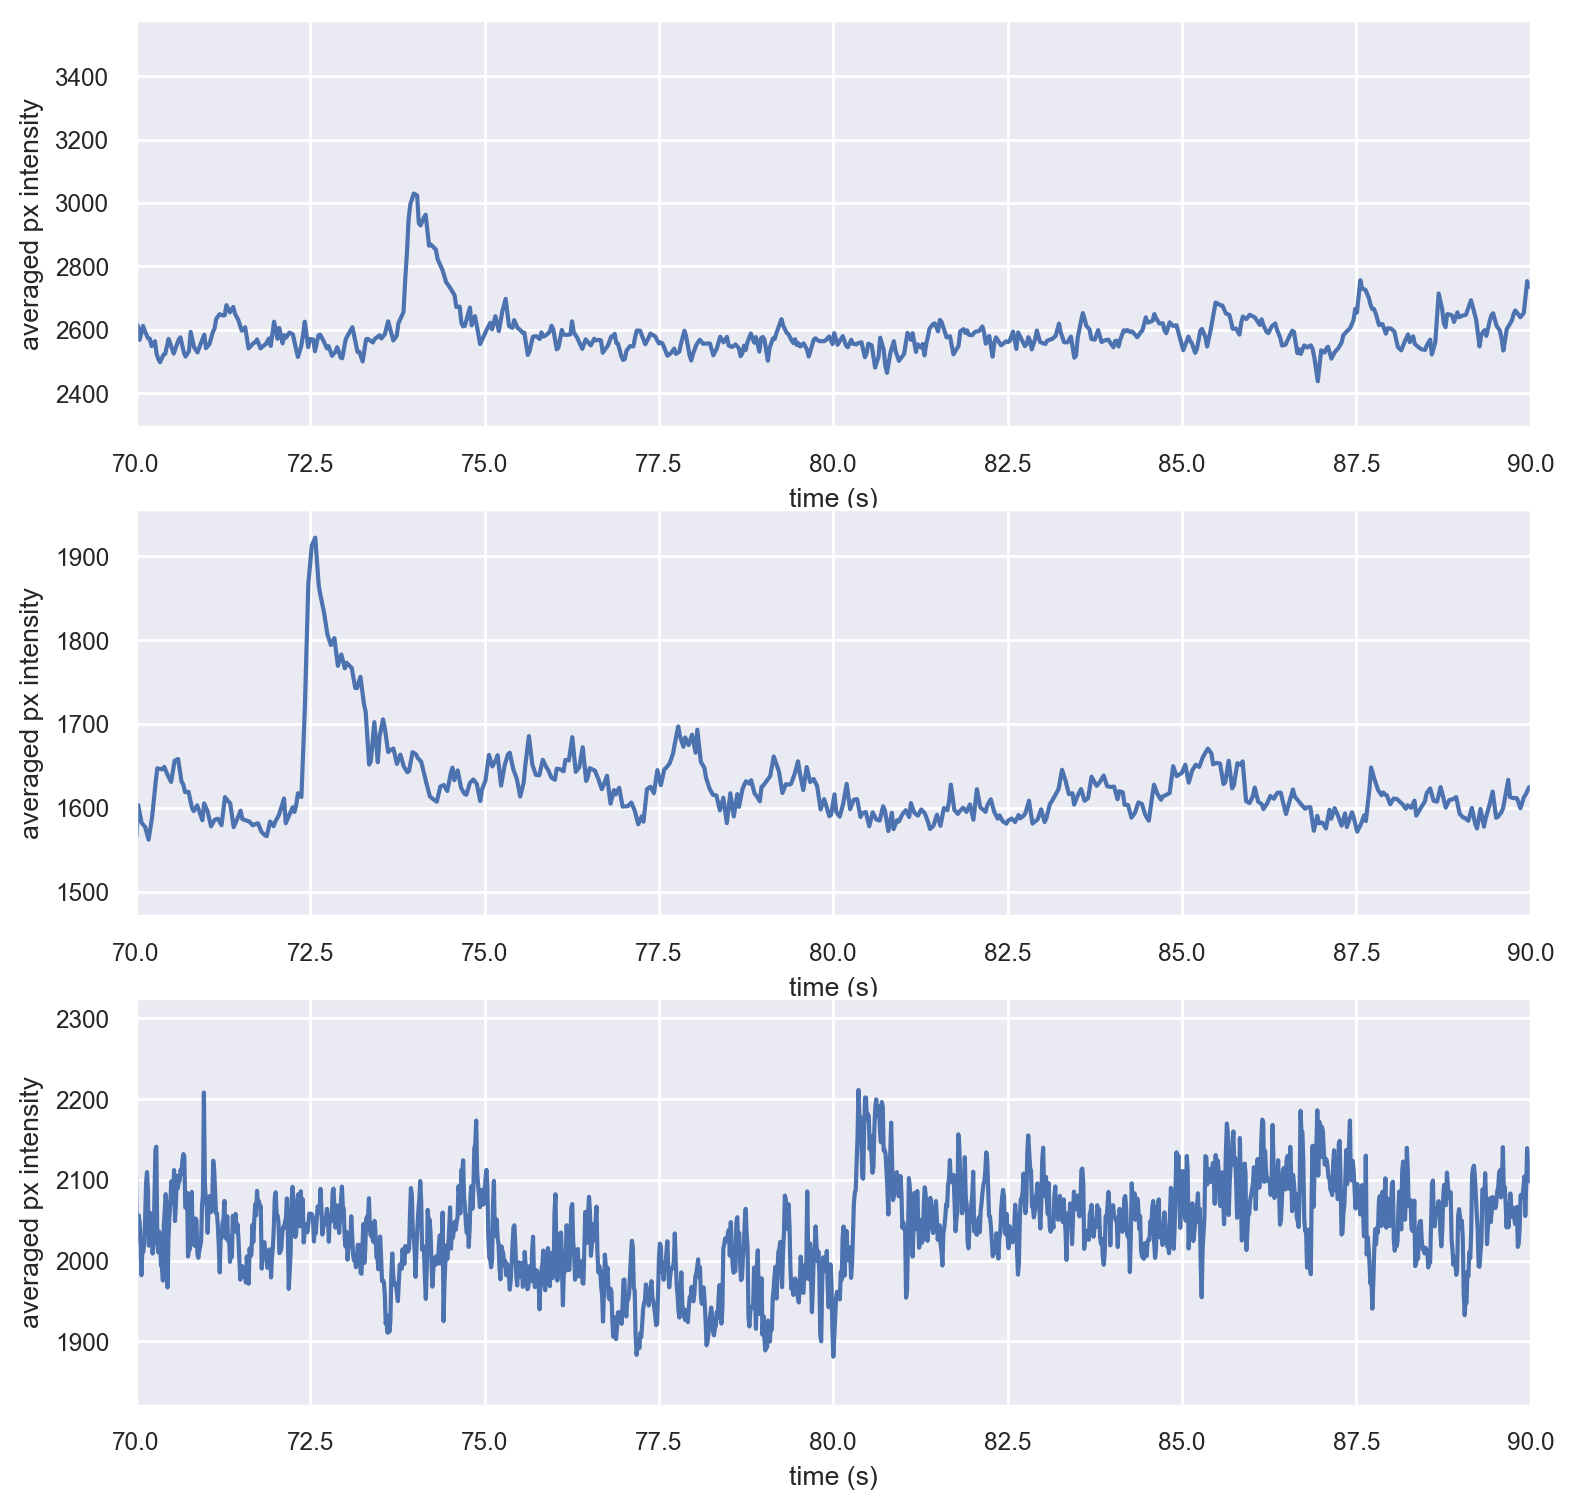

In [8]:
# different animals (expression levels of ), different excitation laser powers,
# system is still changing, green looks too noisy
# downward drift is likely bleaching
GCaMP8s_2 = GCaMP8s_2.loc[GCaMP8s_2["signal"] > 1250]
f, ax = plt.subplots(3, 1, figsize=(9, 9))
ax[0].plot(GCaMP8s_1["time"], GCaMP8s_1["signal"], label="1")
ax[1].plot(GCaMP8s_2["time"], GCaMP8s_2["signal"], label="2")
ax[2].plot(GCaMP8s_3["time"], GCaMP8s_3["signal"], label="3")
for a in ax:
    a.set(xlabel=r"time (s)", ylabel="averaged px intensity", xlim=[70, 90])
plt.show()

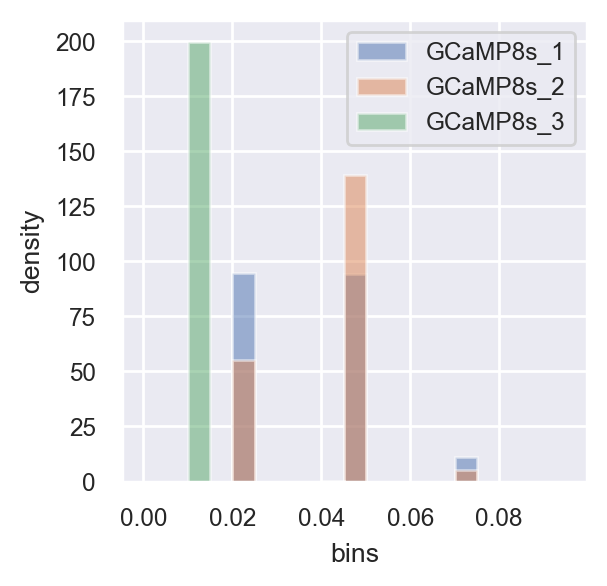

In [9]:
f, ax = plt.subplots(1, 1, figsize=(3, 3))
_ = plt.hist(GCaMP8s_1["time"].diff(), density=True, bins=np.arange(0, 0.1, 0.005), alpha=0.5, label="GCaMP8s_1")
_ = plt.hist(GCaMP8s_2["time"].diff(), density=True, bins=np.arange(0, 0.1, 0.005), alpha=0.5, label="GCaMP8s_2")
_ = plt.hist(GCaMP8s_3["time"].diff(), density=True, bins=np.arange(0, 0.1, 0.005), alpha=0.5, label="GCaMP8s_3")
ax = plt.gca()
ax.set(xlabel="bins", ylabel="density")
plt.legend()
plt.show()

In [10]:
# frames are dropped, sampling rates are not exactly the same. Timestamps are accurate.
print("Mean time interval between frames")
for df in [GCaMP8s_1, GCaMP8s_2, GCaMP8s_3]:
    print(f'{df["time"].diff().mean():0.4f} seconds')

Mean time interval between frames
0.0388 seconds
0.0436 seconds
0.0134 seconds


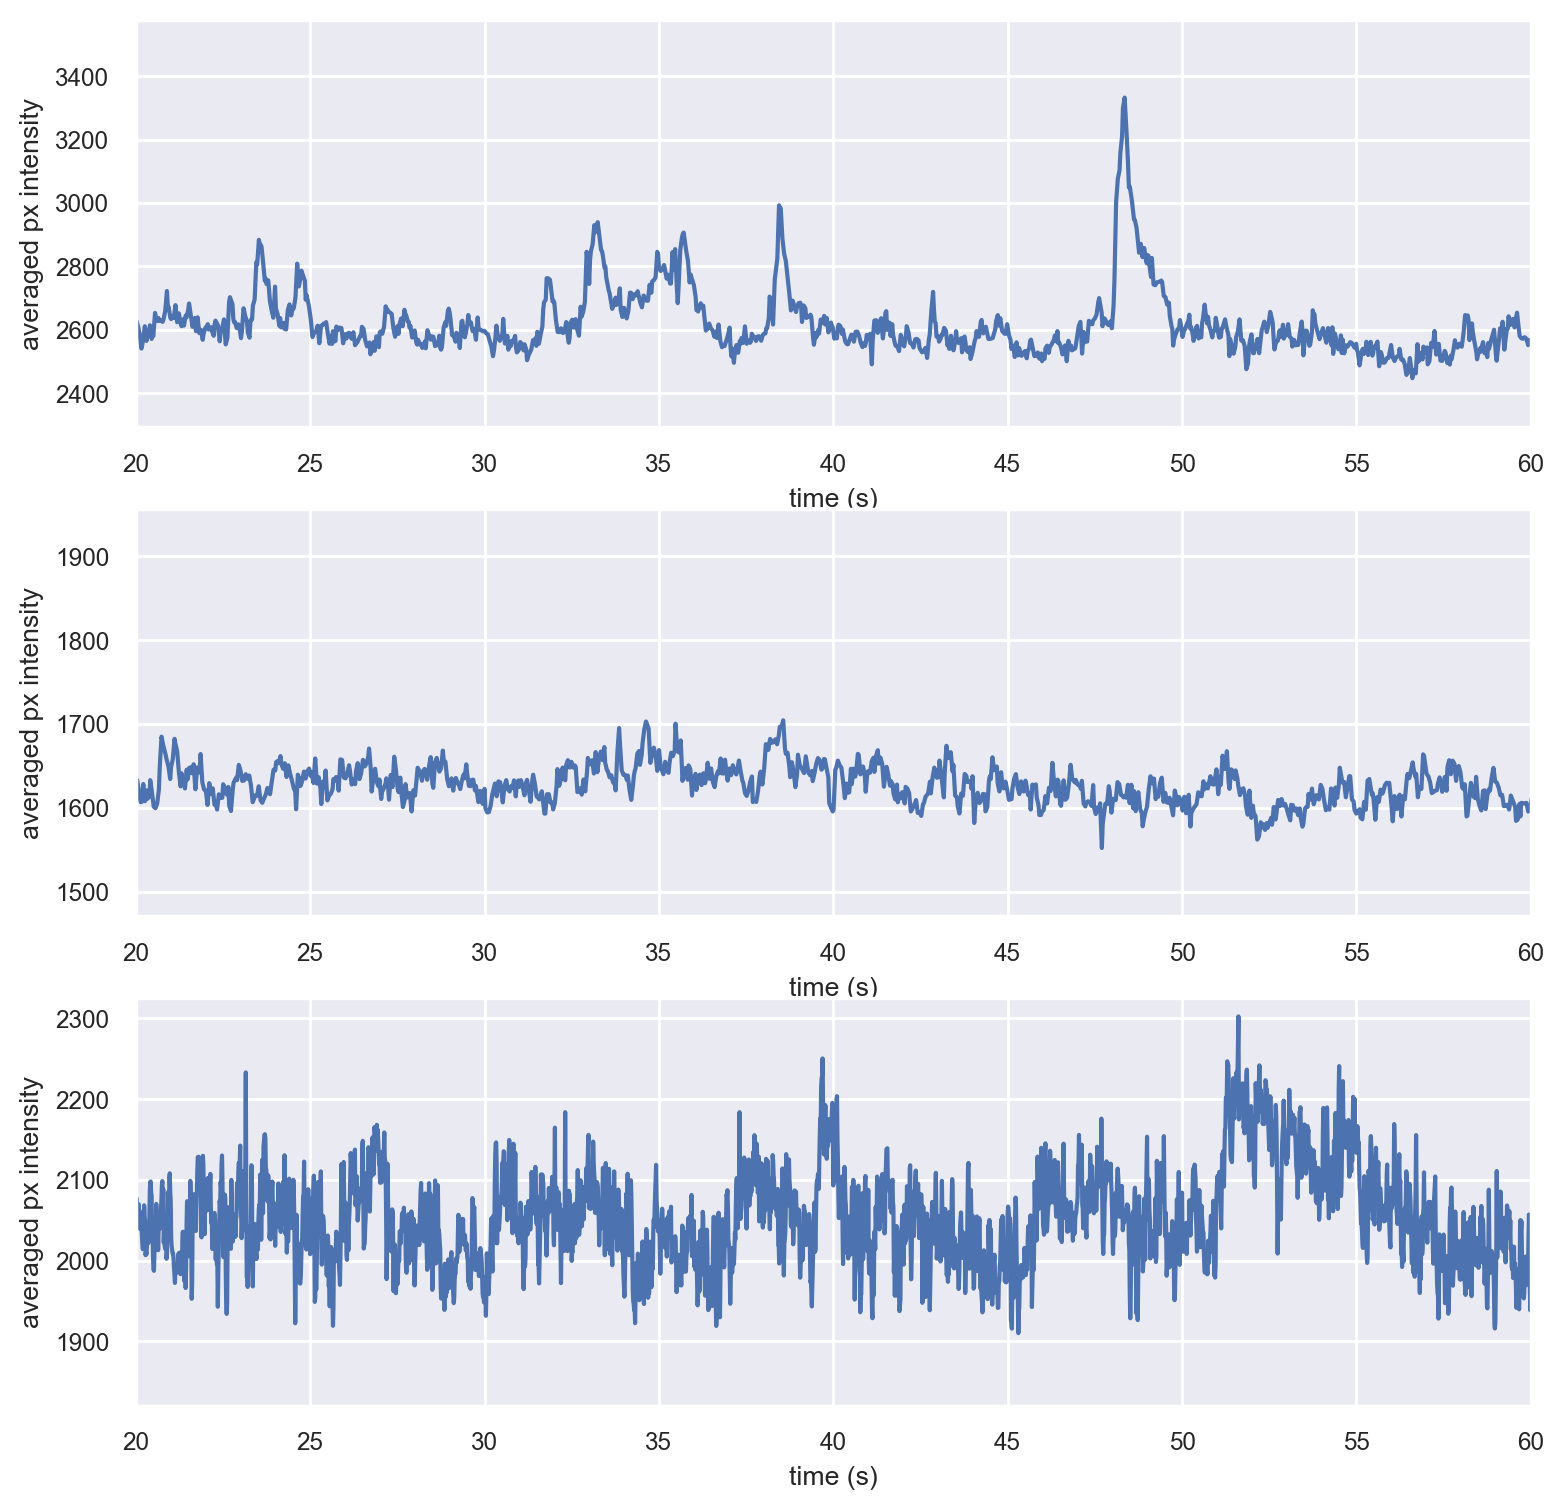

In [11]:
# Inspecting a smaller time interval across recordings:
f, ax = plt.subplots(3, 1, figsize=(9, 9))
ax[0].plot(GCaMP8s_1["time"], GCaMP8s_1["signal"], label="1")
ax[1].plot(GCaMP8s_2["time"], GCaMP8s_2["signal"], label="2")
ax[2].plot(GCaMP8s_3["time"], GCaMP8s_3["signal"], label="3")
for a in ax:
    a.set(xlabel=r"time (s)", ylabel="averaged px intensity", xlim=(20, 60))
plt.show()

 - Data is not uniformly sampled (because frames are being dropped)
 - We can compare the power spectra of the interpolated signal to the original signal
 - [`finufft`: FFT for non uniformly sampled data](https://github.com/flatironinstitute/finufft)
 - For now, we'll simply interpolate the data and calculate the power spectrum.


In [12]:
from scipy.fft import fft, fftfreq
from scipy import interpolate


def sample_unif(x, y, sampling_interval=0.02, xlim=(20, 40)):
    fcubic = interpolate.interp1d(x, y, kind="cubic")

    x_unif = np.arange(0, np.max(x), sampling_interval)
    y_unif = fcubic(x_unif)

    # Inspecting a smaller time interval across recordings:
    f, ax = plt.subplots(1, 1, figsize=(8, 3))
    ax.plot(x, y, label="original")
    ax.plot(x_unif, y_unif, label="uniform sampling")
    ax.set(xlabel=r"time (s)", ylabel="averaged px intensity", xlim=xlim)
    plt.legend()
    plt.show()
    return x_unif, y_unif, sampling_interval


def spectrum(xt, sampling_interval=None):
    xf = fft(xt)
    f = fftfreq(xt.size, sampling_interval)

    # one-sided coefficients => take half of the entries of xf, and multiply each by 2
    f = f[0 : (xt.size // 2)]
    c = (2.0 / xt.size) * np.abs(xf[0 : (xt.size // 2)])

    # plot spectrum
    _, ax = plt.subplots(1, 1, figsize=(8, 3))
    ax.plot(f, c)
    ax.set(xlabel="Frequency", ylabel="Coefficient")
    plt.show()
    return f, c

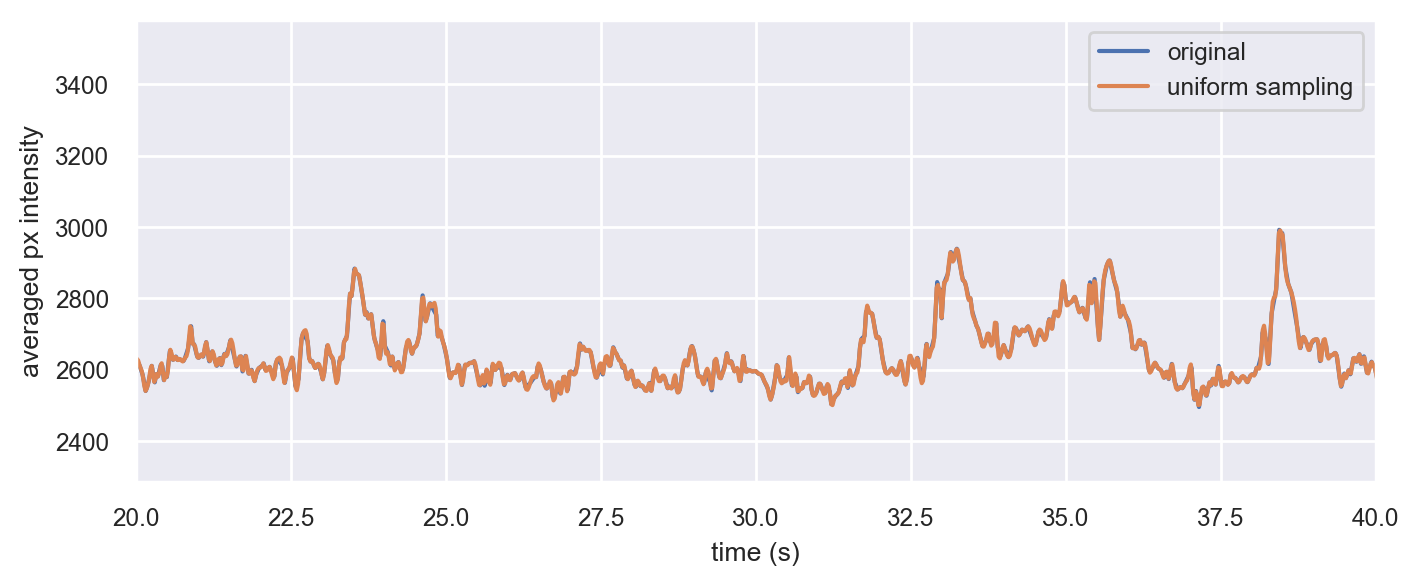

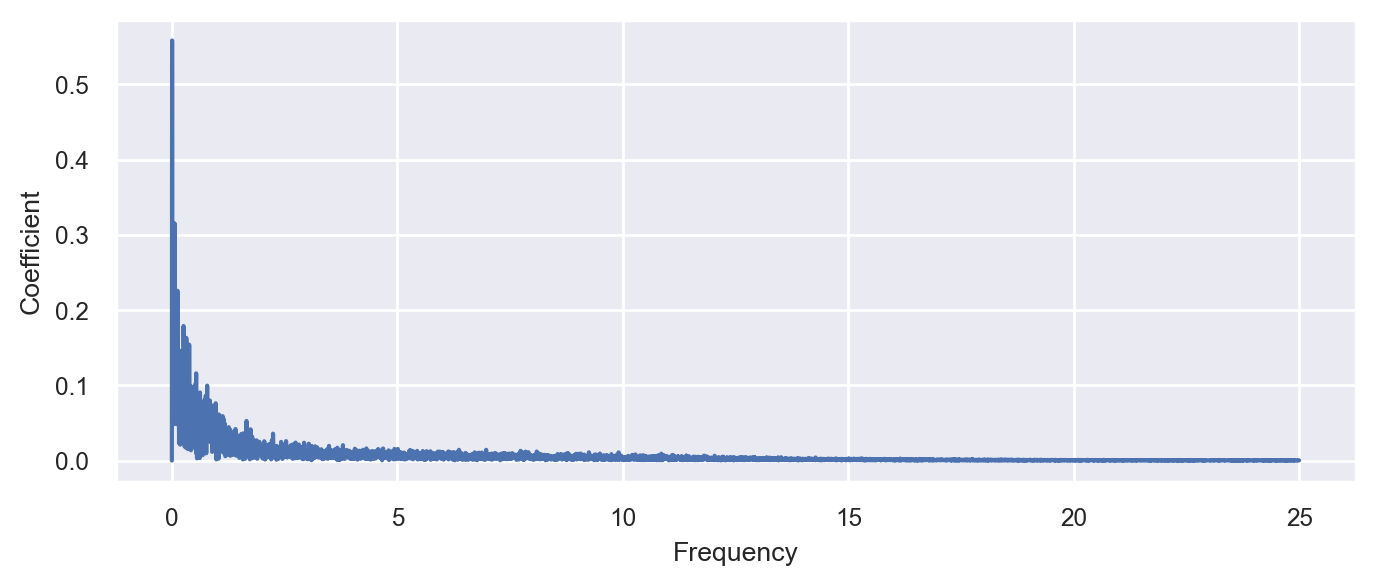

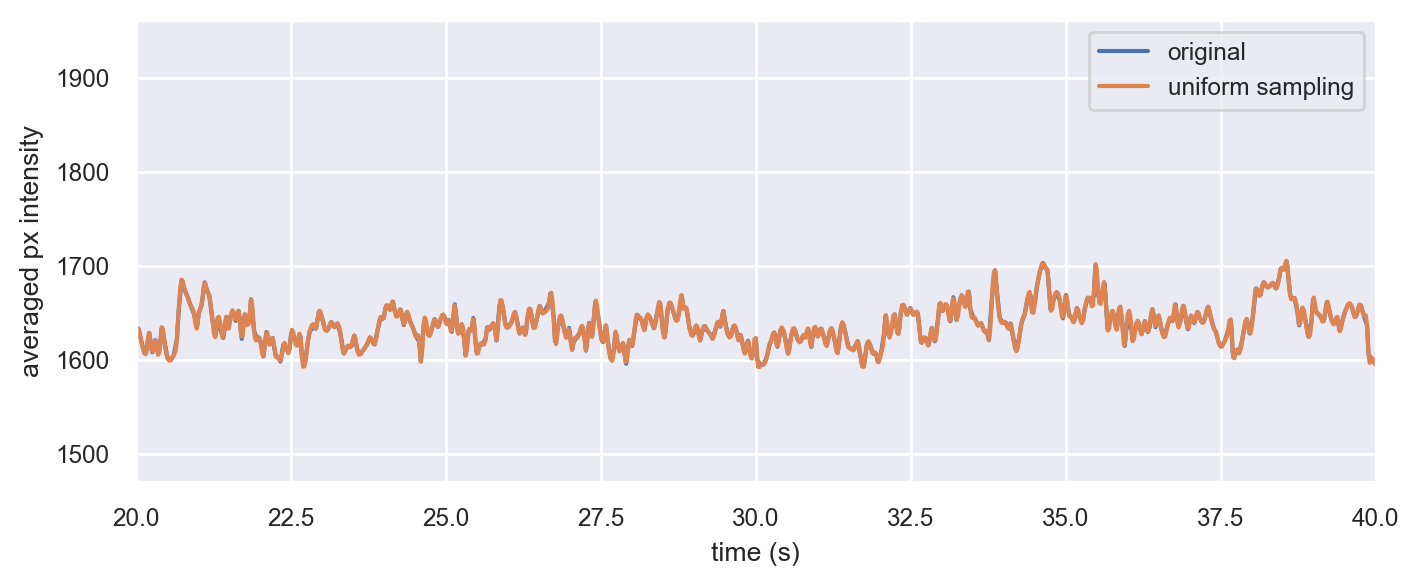

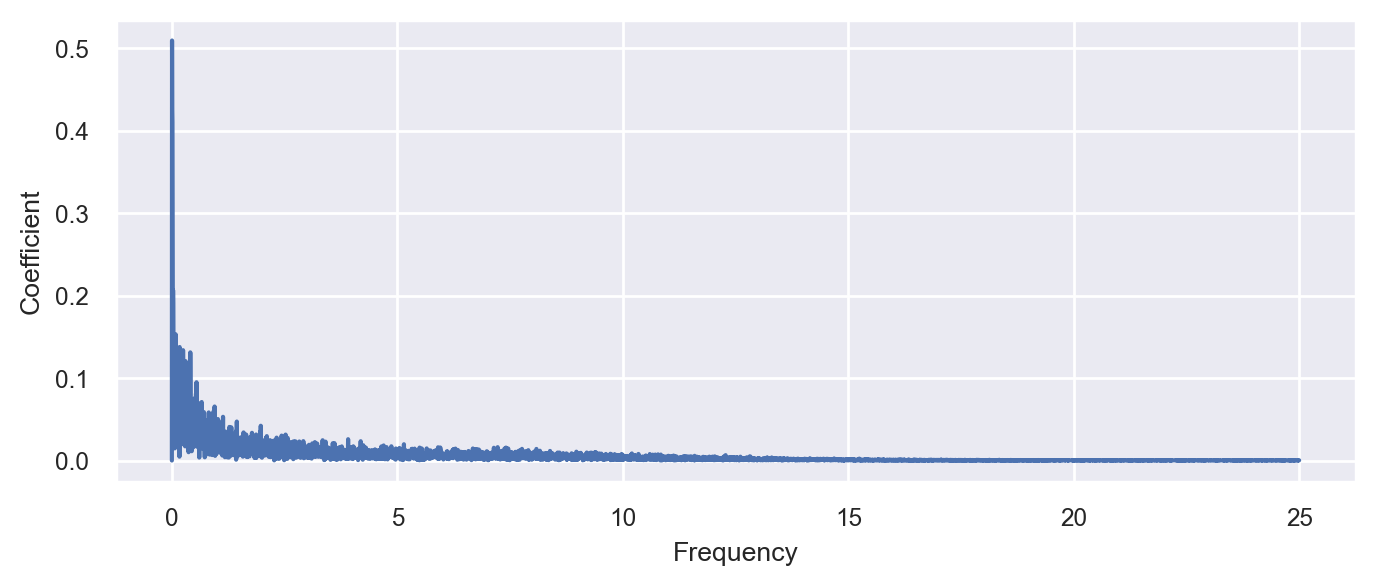

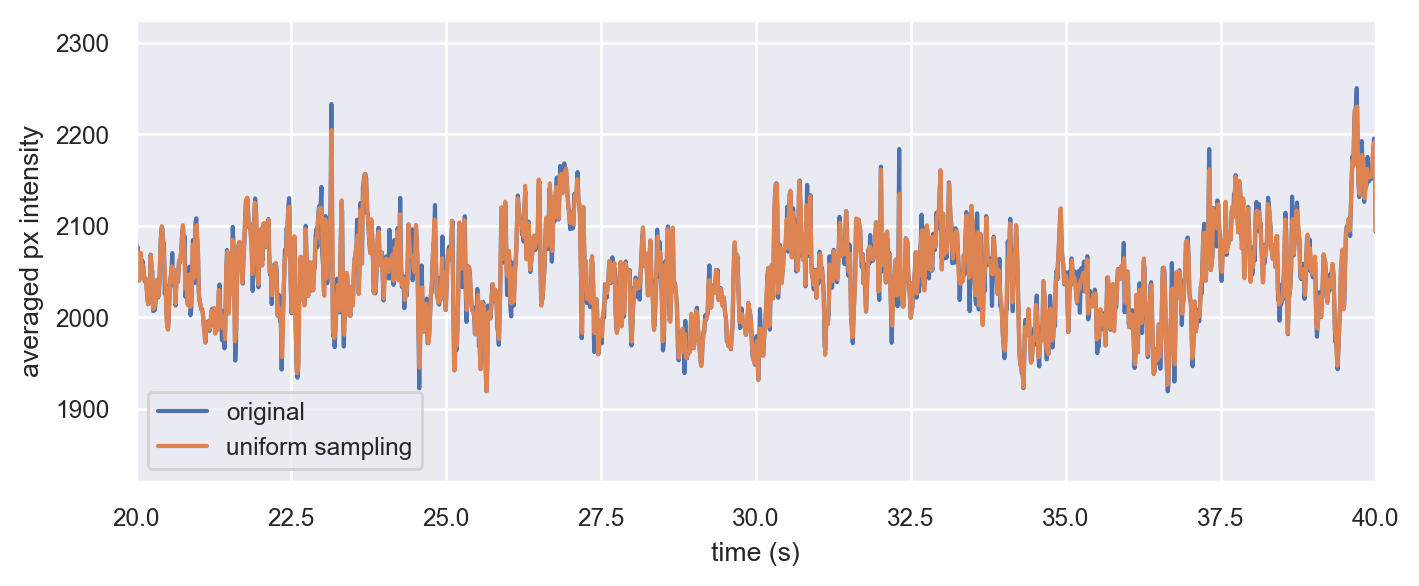

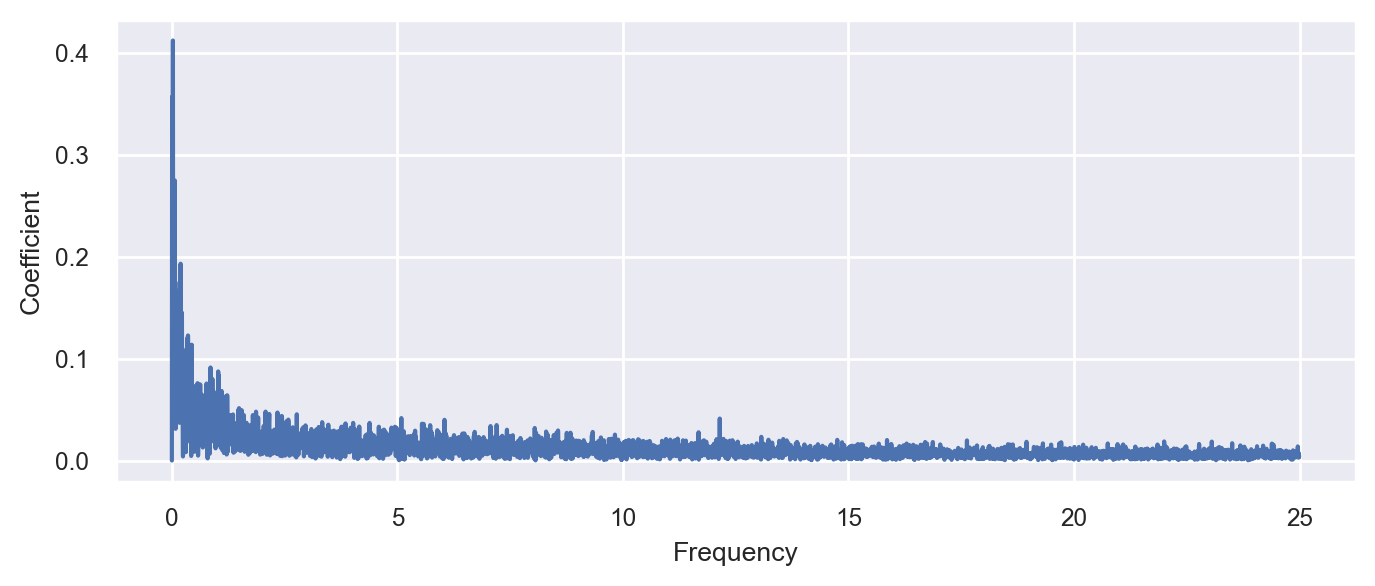

In [13]:
# I'll z-score the values for now, until we can standardize the signal better
t, xt, sampling_interval = sample_unif(x=GCaMP8s_1["time"], y=GCaMP8s_1["signal"], sampling_interval=0.02)
xt = xt - np.mean(xt)
xt = xt / np.std(xt)
f1, c1 = spectrum(xt=xt, sampling_interval=sampling_interval)

t, xt, sampling_interval = sample_unif(x=GCaMP8s_2["time"], y=GCaMP8s_2["signal"], sampling_interval=0.02)
xt = xt - np.mean(xt)
xt = xt / np.std(xt)
f2, c2 = spectrum(xt=xt, sampling_interval=sampling_interval)

t, xt, sampling_interval = sample_unif(x=GCaMP8s_3["time"], y=GCaMP8s_3["signal"], sampling_interval=0.02)
xt = xt - np.mean(xt)
xt = xt / np.std(xt)
f3, c3 = spectrum(xt=xt, sampling_interval=sampling_interval)

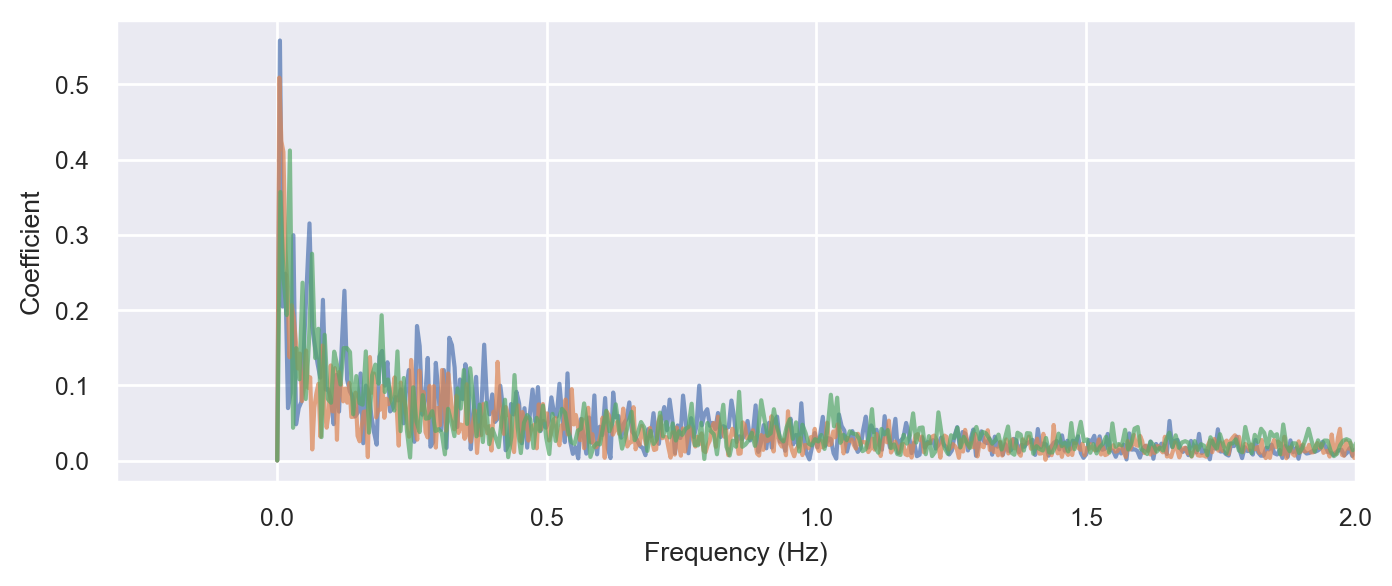

In [14]:
_, ax = plt.subplots(1, 1, figsize=(8, 3))
for f, c in zip([f1, f2, f3], [c1, c2, c3]):
    ax.plot(f, c, "-", alpha=0.7)
    ax.set(xlabel="Frequency (Hz)", ylabel="Coefficient", xlim=(-0.3, 2))
plt.show()

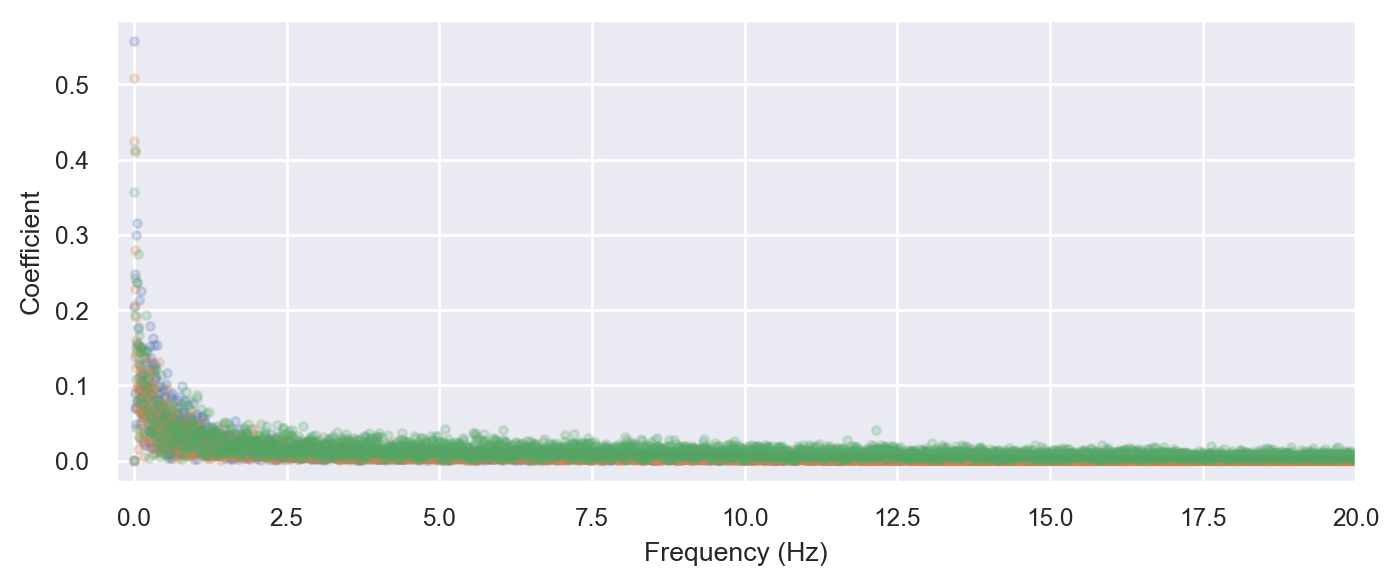

In [15]:
_, ax = plt.subplots(1, 1, figsize=(8, 3))
for f, c in zip([f1, f2, f3], [c1, c2, c3]):
    ax.plot(f, c, ".", alpha=0.2)
    ax.set(xlabel="Frequency (Hz)", ylabel="Coefficient", xlim=(-0.3, 20))
plt.show()

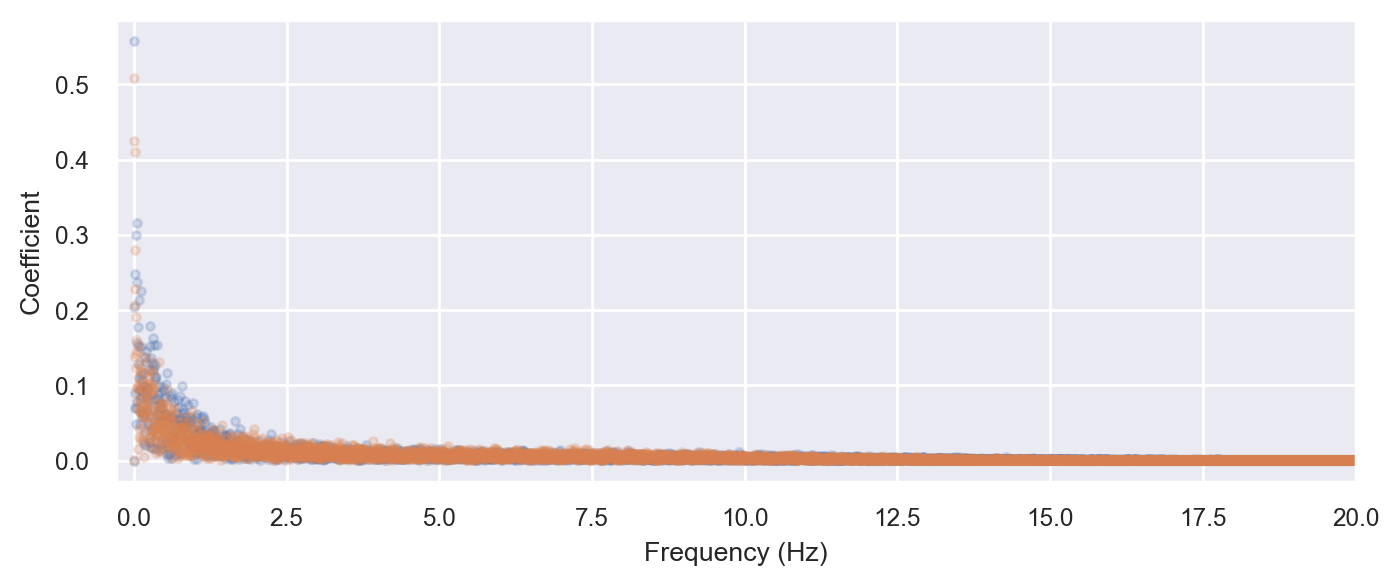

In [16]:
_, ax = plt.subplots(1, 1, figsize=(8, 3))
for f, c in zip([f1, f2], [c1, c2]):
    ax.plot(f, c, ".", alpha=0.2)
    ax.set(xlabel="Frequency (Hz)", ylabel="Coefficient", xlim=(-0.3, 20))
plt.show()

In [17]:
# https://www.janelia.org/jgcamp8-calcium-indicators - this has performance of jGCaMP8s in cultured neurons (df/F, half-life)